# Install Required Libraries

The first step is to install the required libraries. To work with Reddit we need the `praw` library which is the Reddit API wrapper. We also need `nltk` for text processing, `scikit-learn` for machine learning, `matplotlib` and `seaborn` for visualizations, `transformers` and `torch` for creating word embeddings and loading the fine-tuned BERT model and `opendatasets` to load data from Kaggle.

In [ ]:
!pip install praw scikit-learn nltk transformers torch matplotlib seaborn opendatasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 191.0/191.0 kB 9.0 MB/s eta 0:00:00


# Import Libraries and Set up Reddit API
In the next step we import all the necessary libraries and setup a connection to the Reddit API using `praw`. It will help us in streaming comments from subreddits.

In [ ]:
import re
import praw
import torch
import nltk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import opendatasets as od
from google.colab import userdata
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from transformers import AutoModel, AutoModelForSequenceClassification, AutoTokenizer
from transformers import BertForSequenceClassification, BertTokenizer, TextClassificationPipeline

In [ ]:
# Reddit API credentials
REDDIT_CLIENT_ID = userdata.get("client_id")
REDDIT_CLIENT_SECRET = userdata.get("client_secret")
REDDIT_USER_AGENT = userdata.get("user_agent")

# Set up Reddit API connection
reddit = praw.Reddit(client_id=REDDIT_CLIENT_ID,
                     client_secret=REDDIT_CLIENT_SECRET,
                     user_agent=REDDIT_USER_AGENT)


# Clean and Preprocess the text
When dealing with raw text data, it is common to have examples containing symbols, hashtags, slang words, and so on. As these are of no practical use to our model, we must first clean the text in order to remove them.

In [ ]:
# Download stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Clean the text and remove stopwords
def clean_text(text):
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'\W', ' ', text)
    text = re.sub(r'\d', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
    return text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Set up Pretrained BERT Model for Labeling
When we are streaming raw comments from Reddit, we don’t have any idea if the comment is toxic or not because it is unlabeled. To use supervised classification, we first need to have labeled data. We must implement a reliable and precise system for labeling incoming raw comments. For this, we would use a BERT model fine-tuned for hate speech detection. This model will accurately classify the comments into the two categories.

In [ ]:
model_path = "JungleLee/bert-toxic-comment-classification"
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=2)

pipeline = TextClassificationPipeline(model=model, tokenizer=tokenizer)

# Helper function to label the text
def predict_hate_speech(text):
    prediction = pipeline(text)[0]['label']
    return 1 if prediction == 'toxic' else 0 # 1 for toxic, 0 for non-toxic

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Here we use the transformers library to setup the model pipeline. Then we define a helper function to predict whether the given text is toxic or non-toxic using the BERT model. We now have labeled examples to feed into our model.

# Convert text to vectors using BERT embeddings
As our classifier will not work with text inputs, these would need to be converted into a suitable vector representation first. In order to do this, we will use pretrained BERT embeddings, which will convert our text to vectors that can then be fed to the model for training.

In [ ]:
# Load the pretrained BERT model and tokenizer for embeddings
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert_model = AutoModel.from_pretrained(model_name)
bert_model.eval()

# Helper function to get BERT embeddings
def get_bert_embedding(text):
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True)
    with torch.no_grad():
        outputs = bert_model(**inputs)

    return outputs.last_hidden_state[:, 0, :].squeeze().numpy()

The above code takes a piece of text, tokenizes it using a BERT tokenizer, and then passes it through the BERT model to extract the sentence embeddings. The text has now been converted to vectors.

# Stream real-time Reddit data and train Passive-Aggressive Classifier
We are now ready to stream comments in real-time and train our classifier for detecting hate speech.

In [ ]:
# Helper function to stream comments from a subreddit
def stream_comments(subreddit_name, batch_size=100):
    subreddit = reddit.subreddit(subreddit_name)
    comment_stream = subreddit.stream.comments()

    batch = []
    for comment in comment_stream:
        try:
            # Clean the incoming text
            comment_text = clean_text(comment.body)
            # Label the comment using the pretrained BERT model
            label = predict_hate_speech(comment_text)
            # Add the text and label to the current batch
            batch.append((comment_text, label))

            if len(batch) >= batch_size:
                yield batch
                batch = []

        except Exception as e:
            print(f'Error: {e}')


# Specify the number of training rounds
ROUNDS = 10

# Specify the subreddit
subreddit_name = 'Fitness'

# Initialize the Passive-Aggressive classifier
clf = PassiveAggressiveClassifier(C=0.1, loss='hinge', max_iter=1, random_state=37)


# Stream comments and perform incremental training
for num_rounds, batch in enumerate(stream_comments(subreddit_name, batch_size=100)):
    # Train the classifier for a desired number of rounds
    if num_rounds == ROUNDS:
        break

    # Separate the text and labels
    batch_texts = [item[0] for item in batch]
    batch_labels = [item[1] for item in batch]

    # Convert the batch of texts to BERT embeddings
    X_train_batch = np.array([get_bert_embedding(text) for text in batch_texts])
    y_train_batch = np.array(batch_labels)

    # Train the model on the current batch
    clf.partial_fit(X_train_batch, y_train_batch, classes=[0, 1])
    print(f'Trained on batch of {len(batch_texts)} samples.')

print('Training completed')

Trained on batch of 100 samples.
Trained on batch of 100 samples.
Trained on batch of 100 samples.
Trained on batch of 100 samples.
Trained on batch of 100 samples.
Trained on batch of 100 samples.
Trained on batch of 100 samples.
Trained on batch of 100 samples.
Trained on batch of 100 samples.
Trained on batch of 100 samples.
Training completed


In the above code, we first specify the subreddit from which we want to stream comments and then initialize our PA classifier with 10 training rounds. We then stream comments in real time. For each new comment that comes in it first gets cleaned removing unwanted words. Then it is labeled using the pretrained BERT model and added to the current batch.

We initialize our Passive-Aggressive Classifier taking `C=0.1` and `loss='hinge'` which corresponds to the PA-I version of the algorithm. For each batch we train our classifier using the `partial_fit()` method. This allows the model to learn incrementally from each training sample rather than storing the whole batch in memory before processing. Thus, enabling the model to constantly adapt to new information, making it ideal for real-time applications.

# Evaluate Model Performance
I will use the Kaggle toxic tweets dataset to evaluate our model. This dataset contains several tweets that are classified as toxic or non-toxic.

Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86        55
           1       0.87      0.76      0.81        45

    accuracy                           0.84       100
   macro avg       0.85      0.83      0.84       100
weighted avg       0.84      0.84      0.84       100



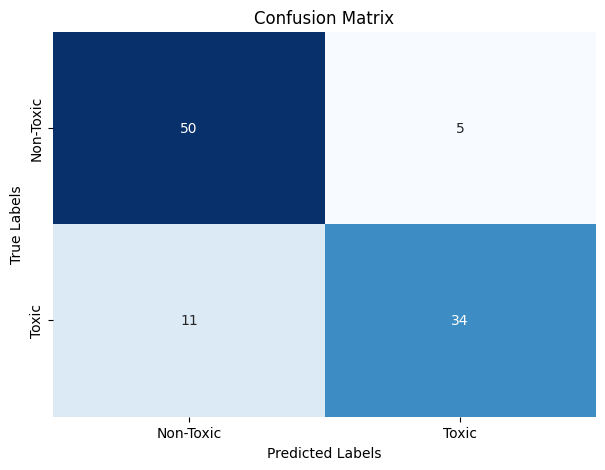

In [ ]:
# Download data from Kaggle
od.download("https://www.kaggle.com/datasets/ashwiniyer176/toxic-tweets-dataset")
# Load the data
data = pd.read_csv("toxic-tweets-dataset/FinalBalancedDataset.csv", usecols=[1,2])[["tweet", "Toxicity"]]

# Separate the text and labels
test_data = data.sample(n=100)
texts = test_data['tweet'].apply(clean_text)
labels = test_data['Toxicity']

# Convert text to vectors
X_test = np.array([get_bert_embedding(text) for text in texts])
y_test = np.array(labels)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the performance of the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Classification Report:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix,
            annot=True,
            fmt='d',
            cmap='Blues',
            cbar=False,
            xticklabels=["Non-Toxic", "Toxic"],
            yticklabels=["Non-Toxic", "Toxic"])

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

First, we loaded the test set and cleaned it with the `clean_text` method defined earlier. The text is then converted into vectors using BERT embeddings. Finally, we make predictions on the test set and evaluate our model's performance on different metrics using classification report and confusion matrix.